In [1]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 1.0MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144793 sha256=edfcd3d0dec12064899dec5d79b650391824b2892a15c97a1283afe9e372ac68
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [10]:
import numpy as np
import pandas as pd
from pandas.io.parsers import StringIO
from io import StringIO
from datetime import date

import Levenshtein as Leven
import random

import seaborn as sns

from google.colab import files

import warnings
warnings.filterwarnings("ignore")

In [3]:
#подгружаем грязные данные
data = pd.read_csv("Data.csv", sep=',')

In [4]:
data.head()

,dept_code,issue_date,issuer,issuer_eng,values;;
0,20003,2001-11-05,ОУФМС,OUFMS,20003_345;;
1,20003,2002-03-22,МВД ПО РЕСПУБЛИКЕ БАШКОРТОСТАН,MVD PO RESPUBLIKE BASHKORTOSTAN,20003_319;;
2,20003,2002-05-18,МВД ПО РЕСПУБЛИКЕ БАШКОРТОСТАН,MVD PO RESPUBLIKE BASHKORTOSTAN,20003_319;;
3,20003,2002-08-13,ОТДЕЛОМ УФМС РОССИИ ПО РЕСПУБЛИКЕ БАШКОРТОСТАН...,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,20003_346;;
4,20003,2003-07-17,ОТДЕЛОМ УФМС РОССИИ ПО РЕСПУБЛИКЕ БАШКОРТОСТАН...,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,20003_347;;


In [5]:
#удаляем неразделяемые строчки (85)
data['failed'] = data['dept_code'].str.contains(';', regex=True)
data = data[data['failed'] == False]

#удаляем наблюдения до 2001 года (ошибки, например, дата заполнения вместо даты рождения)
data['index'] = range(1, len(data) + 1)
data = data[['index', 'dept_code', 'issue_date', 'issuer_eng' ]]
data['issue_date']= pd.to_datetime(data['issue_date'])
data = data[data['issue_date'].dt.strftime('%Y') >= '2001']

In [7]:
#Делим на тестовую и обучающую
np.random.seed()
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [8]:
list(train.columns.values)

['index', 'dept_code', 'issue_date', 'issuer_eng']

In [11]:
#Переводим issue_date в формат даты
train = train[['dept_code', 'issue_date', 'issuer_eng']].drop_duplicates()
test['issue_date']= pd.to_datetime(test['issue_date'])
train['issue_date']= pd.to_datetime(train['issue_date'])

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20880 entries, 9 to 104409
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       20880 non-null  int64         
 1   dept_code   20880 non-null  object        
 2   issue_date  20880 non-null  datetime64[ns]
 3   issuer_eng  20880 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 815.6+ KB


In [13]:
#Соединяем по dept_code и ближайшей issue_date
test = pd.merge_asof(left=test.sort_values('issue_date'), right=train.sort_values('issue_date'), on = 'issue_date', by="dept_code", direction='nearest')

In [14]:
test.head()

,index,dept_code,issue_date,issuer_eng_x,issuer_eng_y
0,34560,282002,2001-01-08,UVD GOR. BLAGOVESCHENSKA,UVD GOR BLAGOVESCHENSKA
1,82300,632033,2001-01-17,AVTOZAVODSKIM RUVD G.TOL'JATTI SAMARSKOJ OBL,AVTOZAVODSKIM RUVD G.TOL'JATTI SAMARSKOJ OBL.
2,34564,282002,2001-01-23,UVD GOR. BLAGOVESCHENSKA,UVD GOR. BLAGOVESCHENSKA
3,82304,632033,2001-02-10,AVTOZAVODSKIM RUVD G. TOL'JATTI SAMARSKOJ OBL.,AVTOZAVODSKIM RUVD G.TOL'JATTI SAMARSKOJ OBL.
4,82306,632033,2001-02-13,AVTOZAVODSKIM RUVD G TOL'JATTI SAMARSKOJ OBL,AVTOZAVODSKIM RUVD G.TOL'JATTI SAMARSKOJ OBL.


In [15]:
#Рассчитываем расстояние Левенштейна между реальными и предсказанными значениями
test['levenshtein'] = 0
for ind in test.index: 
     test['levenshtein'][ind] = Leven.distance(test['issuer_eng_x'][ind], test['issuer_eng_y'][ind])

In [16]:
#Смотрим точность предсказания
test['accuracy'] = np.where(test['issuer_eng_x'] == test['issuer_eng_y'], True, False)
test[test['accuracy']==True].count()[0]/test.count()[0]

0.6409003831417625

In [20]:
print(test['levenshtein'].mean(), test['levenshtein'].median())

1.7269157088122606 0.0


In [ ]:
test.to_csv(r'C:\Users\ASUS\Documents\Machine\tests_l.csv', index = False, header=True)

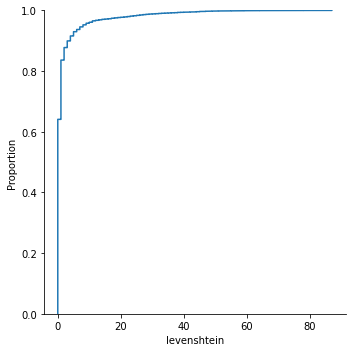

In [17]:
#График распределения расстояния Левенштейна с накоплением
sns.displot(test, x="levenshtein", kind="ecdf")

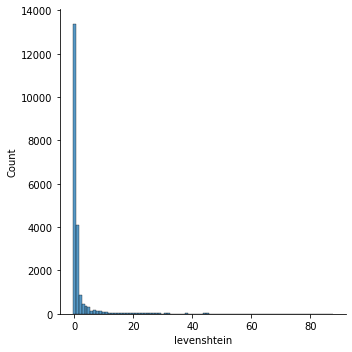

In [19]:
#Гистограмма распределения расстояния Левенштейна
g = sns.displot(test, x="levenshtein", discrete=True)